In [ ]:
import sys
import random

import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import importlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [ ]:
def extract_image_patches(x, kernel, stride=1, dilation=1):
    # Do TF 'SAME' Padding
    b,c,h,w = x.shape
    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = F.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from modules.BciDataHandler import BciDataHandler

data_handler = BciDataHandler()
data_handler.instantiate_dataset()

In [ ]:
# ------------------------------ bci competition dataset ------------------------------
all_subject_epochs = mne.concatenate_epochs(list(data_handler.subjects_epochs.values()))
all_labels = all_subject_epochs.events[:, -1] - 1

epochs = data_handler.subjects_epochs[1]
labels = np.array(data_handler.subjects_labels[1]) - 1

# epochs = all_subject_epochs
# labels = all_labels
# labels

In [408]:
# -------------------------------- ufjf dataset --------------------------------------
from modules.EdfHandler import EdfHandler

epochs, labels = EdfHandler.getAllData(["C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\001.edf"])
epochs = epochs[0]
labels = np.array(labels[0])
labels[labels == 6] = 0

Extracting EDF parameters from C:\Users\davi2\Desktop\bci\datasets_ufjf\bci\001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241499  =      0.000 ...  1931.992 secs...
Used Annotations descriptions: ['LeftExec', 'LeftPrepare', 'NewRun', 'NewTrial', 'Resting', 'RightExec', 'RightPrepare']
Not setting metadata
644 matching events found
Setting baseline interval to [-0.496, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 644 events and 625 original time points ...
0 bad epochs dropped


In [ ]:
#----------------------- physionet dataset -------------------------------------
# import mne
# from mne import Epochs, pick_types, events_from_annotations
# from mne.channels import make_standard_montage
# from mne.io import concatenate_raws, read_raw_edf
# from mne.datasets import eegbci


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
# tmin, tmax = -1., 4.
# event_id = dict(handsOrLeft=2, feetOrRight=3)
#
# def get_physionet_data(subject, runs):
#
#     raw_fnames = eegbci.load_data(subject, runs)
#     raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
#     eegbci.standardize(raw)  # set channel names
#     montage = make_standard_montage('standard_1005')
#     raw.set_montage(montage)
#
#     # Apply band-pass filter
#     raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
#
#     events, _ = events_from_annotations(raw)
#
#     picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
#                        exclude='bads')
#
#     # Read epochs (train will be done only between 1 and 2s)
#     # Testing will be done with a running classifier
#     epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
#                     baseline=None, preload=True)
#
#     epochs_data = epochs.copy().crop(tmin=1., tmax=2.)
#
#     labels = epochs.events[:, -1] - 2
#
#     return epochs_data, labels


# [6, 10, 14] hands vs feet
#[4, 8, 12] left vs right hand
# X_hf, y_hf = get_physionet_data(subject=1, runs=[6, 10, 14])
# X_lr, y_lr = get_physionet_data(subject=1, runs=[4, 8, 12])
#
# epochs = mne.concatenate_epochs([X_hf, X_lr])
# labels = np.concatenate([y_hf, y_lr+2])

In [ ]:
# def plot_psd(data, axis, label, color):
#     psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq,
#                                                           fmin=0.1, fmax=100)
#     psds = 10. * np.log10(psds)
#     psds_mean = psds.mean(0).mean(0)
#     axis.plot(freqs, psds_mean, color=color, label=label)
#
#
# _, ax = plt.subplots()
# plot_psd(X, ax, 'original', 'k')
# plot_psd(X_tr.numpy(), ax, 'shifted', 'r')
#
# ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
#        ylabel='Power Spectral Density (dB)')
# ax.legend()
# plt.show()

In [ ]:
from torch import nn
from Models.SubModules import ViewConv, DepthWiseConv2d, SeparableConv2d, Unsqueeze, PositionalEncoding, ToTransformer, \
    MaxNormLayer, FeatureExtraction, EmbeddingLayer, VisionTransformer
import torch.nn.functional as F


class EEGNET(nn.Module):
    def __init__(
            self,
            n_times,
            n_classes,
            n_channels,
            patches=16,
            embedding_dim=8,
            dropout_rate=0.1,
            transformer_ffd=128,
            max_norm=0.25,
            F1=8,
            F2=16,
            D=2,
            pool1_stride=4,
            pool2_stride=8,
            kernel_length=4,
            channel_depht=1
    ):
        super().__init__()
        self.feature_extraction_output = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1)

        self.feature_extraction = FeatureExtraction(n_channels=n_channels, kernel_length=kernel_length, F1=F1, D=D, F2=F2, pool1_stride=pool1_stride, pool2_stride=pool2_stride)

        self.embedding = EmbeddingLayer(n_times=self.feature_extraction_output, patches_num=patches, embedding_dim=embedding_dim, dropout_rate=dropout_rate)

        self.transformer = VisionTransformer(patches=patches, transformer_ffd=transformer_ffd)

        # self.conv_simplifier = ConvolutionSimplifier(embedding_dim=embedding_dim, dropout_rate=dropout_rate)

        self.head = nn.Sequential(
            nn.Linear(in_features=patches, out_features=1),
            nn.Dropout(dropout_rate),
            nn.ELU(),
            nn.Flatten(),
            MaxNormLayer(in_features=embedding_dim, out_features=n_classes, max_norm=max_norm),
        )


    def forward(self, x, targets):
        out_values = {}
        out = self.feature_extraction(x)
        out = self.embedding(out)
        out = self.transformer(out)
        # out = self.conv_simplifier(out)
        logits = self.head(out)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss, out_values

In [415]:
#data augmentation
from braindecode.augmentation import FrequencyShift
from braindecode.augmentation import GaussianNoise

sfreq = epochs.info['sfreq']

freq_shift = FrequencyShift(
    probability=0.5,  # defines the probability of actually modifying the input
    sfreq=sfreq,
    max_delta_freq=2.  # the frequency shifts are sampled now between -2 and 2 Hz
)

gauss_noise = GaussianNoise(
    probability=0.5,
    std=0.01
)

transforms = {
    'freq': freq_shift,
    'gauss': gauss_noise
}

In [416]:
X = torch.tensor(epochs.get_data()).to(dtype=torch.float32, device=device)
y = torch.tensor(labels).to(dtype=torch.long, device=device)

In [417]:
model = EEGNET(n_times=X.shape[-1], n_channels=len(epochs.picks), n_classes=len(set(labels)))
model = model.to(device=device)

In [418]:
seed = 1330
splits = 5
lr=3e-3

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.3)

loss: 0.7162148952484131 iteration: 100/2000


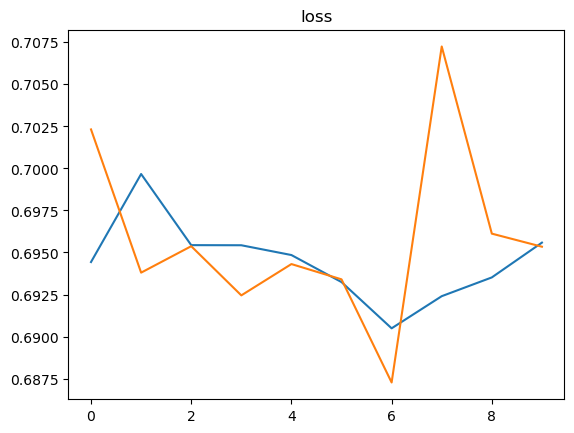

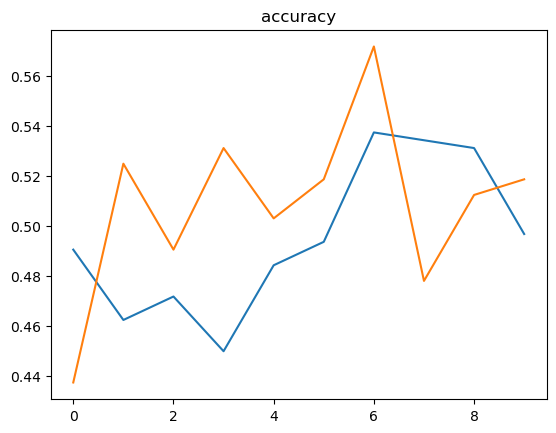

loss: 0.6593769192695618 iteration: 200/2000


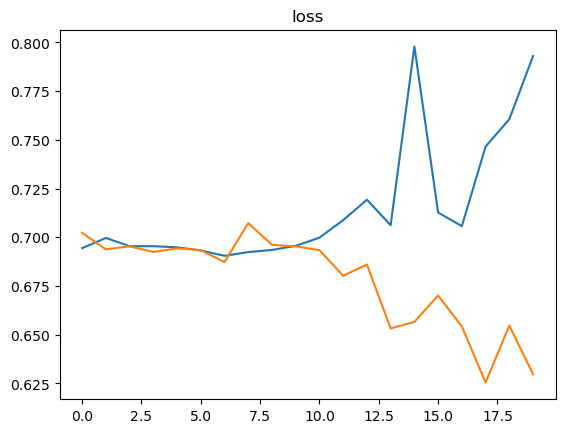

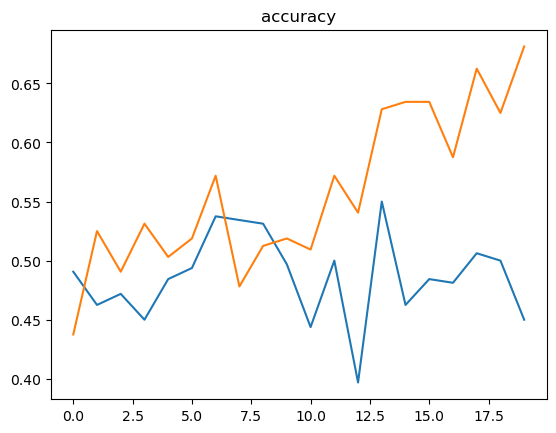

In [ ]:
from modules.TrainTester import TrainerTester

ud = []

#main-trianing-loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index],
    y_train, y_test = y[train_index], y[test_index]

    TrainerTester.train_loop(model, optimizer, X_train, y_train, X_test, y_test, lr, ud, batch_size=32, iterations=2000)

    out_values = TrainerTester.test_loop(model, X_test, y_test)
    break

In [ ]:
#params evaluation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, np.prod(param.size()))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total: ', params)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
meta_step_size = 0.25

meta_iters = 5000

eval_interval = 100
train_shots = 40
eval_shots = 4
classes = 4

batch_size = 1
#obs: total shots = classes * shots

n_times=X.shape[-1]
n_channels=len(epochs.picks)

seed = 1330
splits = 5
lr=1e-4

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

train_index, test_index = skf.split(X, y).__next__()
X_train, X_test = X[train_index], X[test_index],
y_train, y_test = y[train_index], y[test_index]

In [ ]:
class Dataset:
    def __init__(self, training):
        split = "train" if training else "test"

        if split:
            X_dataset, y_dataset = X_test, y_test
        else:
            X_dataset, y_dataset = X_train, y_train

        self.data = {}

        for value, label in zip(X_dataset, y_dataset):
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(value)
        self.labels = list(self.data.keys())

    def get_mini_dataset(self, shots, num_classes, split=False):
        temp_labels = torch.zeros((num_classes * shots))
        temp_X = torch.zeros((num_classes * shots, n_channels, n_times))
        if split:
            test_labels = torch.zeros((num_classes * eval_shots))
            test_X = torch.zeros((num_classes * eval_shots, n_channels, n_times))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                X_to_split = torch.stack(random.choices(self.data[label_subset[class_idx]], k=shots + 1))
                test_X[class_idx] = X_to_split[-1]
                temp_X[class_idx * shots : (class_idx + 1) * shots] = X_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_X[class_idx * shots : (class_idx + 1) * shots] = \
                    torch.stack(random.choices(self.data[label_subset[class_idx]], k=shots))

        temp_X, temp_labels = unison_shuffled_copies(temp_X, temp_labels)
        temp_X, temp_labels = torch.stack(temp_X.chunk(batch_size)), torch.stack(temp_labels.chunk(batch_size))
        dataset = zip(temp_X, temp_labels)

        if split:
            test_X, test_labels = unison_shuffled_copies( test_X, test_labels)
            return dataset, test_X, test_labels
        return dataset

train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    frac_done = meta_iter / meta_iters

    cur_meta_step_size = (1 - frac_done) * meta_step_size

    old_vars = model.state_dict()

    mini_dataset = train_dataset.get_mini_dataset(
        train_shots, classes
    )

    for X_values, y_labels in mini_dataset:
        y_labels = y_labels.to(dtype=torch.long)
        preds, loss, out_values = model(X_values, y_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"meta train loss: {loss}")

    new_vars = model.state_dict()

    for key, var in new_vars.items():
        new_vars[key] = old_vars[key] + ((new_vars[key] - old_vars[key]) * cur_meta_step_size)

    model.load_state_dict(new_vars)


    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # print("test dataset reset!\n")
            # Sample a mini dataset from the full dataset.
            train_set, test_X, test_labels = dataset.get_mini_dataset(
                eval_shots, classes, split=True
            )
            old_vars = model.state_dict()

            for X_values, y_labels in train_set:
                y_labels = y_labels.to(dtype=torch.long)

                preds, test_loss, out_values = model(X_values, y_labels)

                optimizer.zero_grad()
                test_loss.backward()
                optimizer.step()
            print(f"test loss: {test_loss}")

            test_labels = test_labels.to(dtype=torch.long)
            test_preds, test_loss, test_out_values = model(test_X, test_labels)

            accuracy = (test_preds.argmax(1) == test_labels).type(torch.float32).sum().item() / test_labels.shape[0]
            accuracies.append(accuracy)

            model.load_state_dict(old_vars)

        training.append(accuracies[0])
        testing.append(accuracies[1])

        print(f"batch {meta_iter}: train={accuracies[0]} test={accuracies[1]}")

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

In [ ]:
# model.load_state_dict(torch.load('model_states/test_model_states.txt'))
# torch.save(model.state_dict(), 'model_states/test_model_states.txt')